## Training a Random Forests Model

In [1]:
import os

from qsprpred.models import SklearnModel
from qsprpred.data import QSPRDataset
from qsprpred.models import OptunaOptimization
from qsprpred.models import CrossValAssessor
from sklearn.ensemble import RandomForestClassifier
from qsprpred.data import RandomSplit, BootstrapSplit
from qsprpred.data.descriptors.fingerprints import MorganFP


os.makedirs("../output/models", exist_ok=True)

# Read receptor name from the text file
#with open("../output/data/receptor.txt", "r") as file:
 #   receptor = file.read().strip() #this is temporarily commented out to focus on new filtered hERG dataset compared to orginal

dataset = QSPRDataset.fromTableFile(
    filename=f"../output/data/hERG_Dataset_filtered.tsv",
    store_dir="../output/data",
    name=f"SplittinghERG_F_Dataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "SINGLECLASS", "th": [6.5]}],
    random_state=42
)

dataset.addDescriptors([MorganFP(radius=3, nBits=2048)])
dataset.getDescriptors().shape

def print_split(ds):
    train, test = ds.getFeatures()
    print(train.shape)
    print(test.shape)
    print(test.index)


print_split(dataset)

(11709, 2048)
(0, 2048)
Index([], dtype='object', name='QSPRID')


In [3]:
# Create the splitter
split = RandomSplit(test_fraction=0.2)

# Split the dataset
dataset.split(split)

# Check split sizes
print_split(dataset)

model = SklearnModel( #test with new model types
    base_dir="../output/models/",
    alg=RandomForestClassifier,
    name="SplittinghERG_F_Model",
    random_state=dataset.randomState
)
search_space_bs = {"n_estimators": ["int", 10, 100, 250]}
optimizer = OptunaOptimization(
    param_grid=search_space_bs,
    n_trials=6,  
    model_assessor=CrossValAssessor(
        scoring="roc_auc",
        split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=5)
    )
)
optimizer.optimize(model, dataset)

qsprpred - WARNING - Explicitly specified random state (42)will override model settings read from file: 42.
[I 2025-03-18 11:45:19,551] A new study created in memory with name: no-name-dc067a9c-4773-4221-9b1e-dccdf91c5a73


(9367, 2048)
(2342, 2048)
Index(['SplittinghERG_F_Dataset_09894', 'SplittinghERG_F_Dataset_04880',
       'SplittinghERG_F_Dataset_06521', 'SplittinghERG_F_Dataset_07013',
       'SplittinghERG_F_Dataset_04092', 'SplittinghERG_F_Dataset_01383',
       'SplittinghERG_F_Dataset_09677', 'SplittinghERG_F_Dataset_06889',
       'SplittinghERG_F_Dataset_08844', 'SplittinghERG_F_Dataset_04043',
       ...
       'SplittinghERG_F_Dataset_08956', 'SplittinghERG_F_Dataset_03000',
       'SplittinghERG_F_Dataset_03265', 'SplittinghERG_F_Dataset_05882',
       'SplittinghERG_F_Dataset_11359', 'SplittinghERG_F_Dataset_11348',
       'SplittinghERG_F_Dataset_01746', 'SplittinghERG_F_Dataset_04819',
       'SplittinghERG_F_Dataset_08167', 'SplittinghERG_F_Dataset_10490'],
      dtype='object', name='QSPRID', length=2342)


[I 2025-03-18 11:46:06,511] Trial 0 finished with value: 0.6800141925850258 and parameters: {'n_estimators': 44}. Best is trial 0 with value: 0.6800141925850258.
[I 2025-03-18 11:47:47,085] Trial 1 finished with value: 0.6818608158108035 and parameters: {'n_estimators': 96}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:49:09,123] Trial 2 finished with value: 0.6814536630987152 and parameters: {'n_estimators': 76}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:50:15,412] Trial 3 finished with value: 0.6812726843393605 and parameters: {'n_estimators': 64}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:50:40,514] Trial 4 finished with value: 0.6763280140651349 and parameters: {'n_estimators': 24}. Best is trial 1 with value: 0.6818608158108035.
[I 2025-03-18 11:51:05,567] Trial 5 finished with value: 0.6763280140651349 and parameters: {'n_estimators': 24}. Best is trial 1 with value: 0.6818608158108035.


{'n_estimators': 96}

### Bootstrapping with optimized model

In [4]:
# run bootstrapping ten times with the optimized model
CrossValAssessor(
    scoring="roc_auc",
    split=BootstrapSplit(split=RandomSplit(0.2), n_bootstraps=10)
)(model, dataset)

array([0.68362769, 0.67459206, 0.68807712, 0.69073916, 0.67226805,
       0.66486307, 0.67811979, 0.67388341, 0.67112835, 0.69248732])

In [5]:
# evaluate on the test set as well
from qsprpred.models import TestSetAssessor

TestSetAssessor(scoring="roc_auc")(model, dataset)

array([0.68057551])

In [5]:
import joblib

# save the model
joblib.dump(model, "SplittinghERG_F_Model.pkl")
#_ = model.save() 
#for some reason this does not properly save the model, need to investigate why further.

['SplittinghERG_F_Model.pkl']

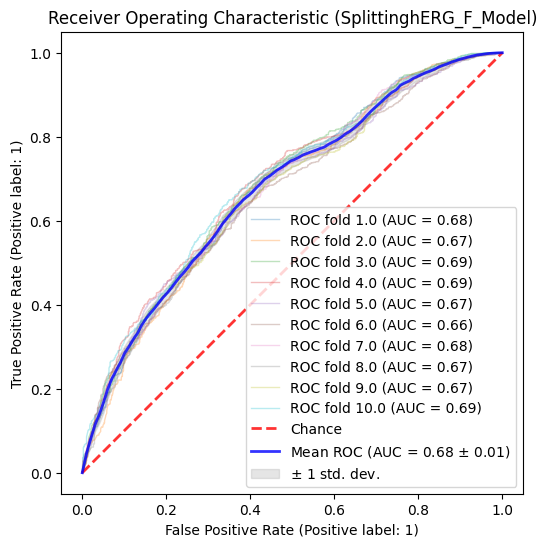

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [6]:
# plot the results for bootstrapping
from qsprpred.plotting.classification import ROCPlot

plot = ROCPlot([model])
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

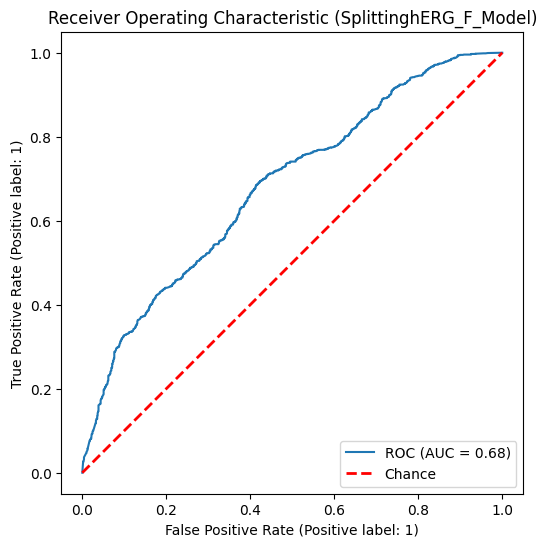

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [7]:
# plot test set results
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="ind")

## Cross validation using ScaffoldSplit

In [8]:
from qsprpred.data import ScaffoldSplit
from qsprpred.models import SklearnModel
from qsprpred.models import CrossValAssessor

CrossValAssessor(
    scoring="roc_auc",
    split=ScaffoldSplit(n_folds=10, scaffold=BemisMurckoRDKit())
)(model, dataset)

NameError: name 'BemisMurckoRDKit' is not defined

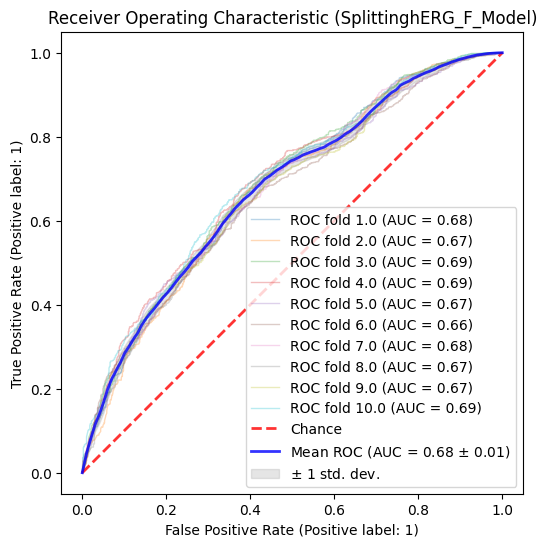

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [9]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

## Cross validation using Temporal split

<Axes: >

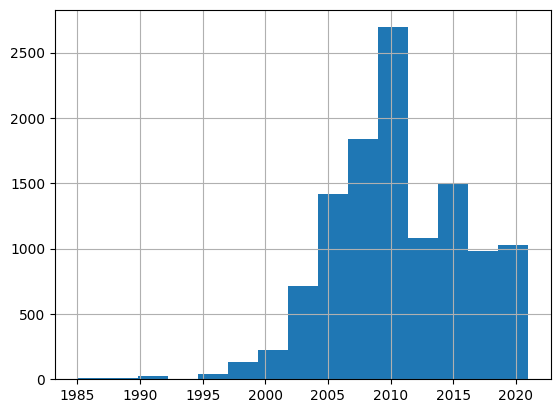

In [10]:
dataset.getProperty("Year").hist(bins=15)

In [11]:
from qsprpred.data import TemporalSplit

CrossValAssessor(
    scoring="roc_auc",
    split=TemporalSplit(timesplit=[2000, 2010, 2020], timeprop="Year")
)(model, dataset)

array([0.54811073, 0.60834031, 0.4978355 ])

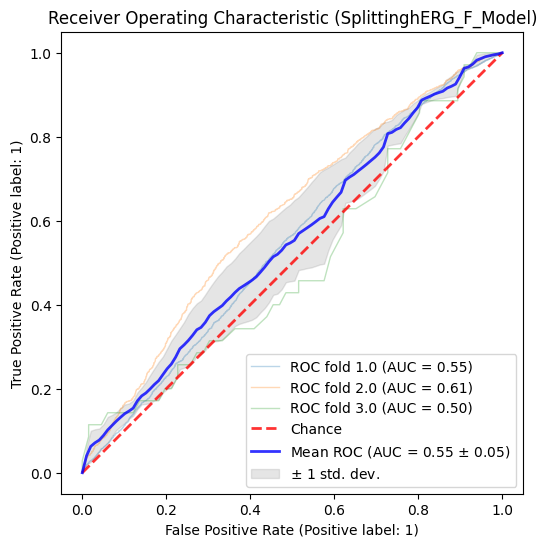

[<Figure size 600x600 with 1 Axes>]

<Figure size 640x480 with 0 Axes>

In [12]:
plot.make(save=True, show=True, property_name=model.targetProperties[0].name,
          validation="cv")

These splits are not saved to the dataset, but the assessments and optimizations can be reproduced by setting the random state to the same value. You can also explicitly save the splits to by adding a monitor to the `ModelAssessor` or `HyperparameterOptimizer`, see the [monitoring tutorial](../../advanced/modelling/monitoring.ipynb) for more information.

### Making predictions

In [13]:
smiles_list = ["c1(cc(c(O)cc1)O)CCN", "CC(=O)OC1=CC=CC=C1C(=O)O",
               "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]

model.predictMols(smiles_list)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Reloading

In [ ]:
dataset = QSPRDataset.fromFile(
    "./output/data/{receptor}_Dataset/{receptor}Dataset_meta.json")
model = SklearnModel.fromFile(
    "./output/models/{receptor}_Model/QuickStartModel_meta.json")
# or
dataset = QSPRDataset(
    name="{receptor}_Dataset",
    store_dir="./data/",
)
model = SklearnModel(
    name="{receptor}Model",
    base_dir="./output/models/"
)